# Depression Classification

---
### Import Necessary Libraries

In [ ]:
from wordcloud import WordCloud
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
import neattext.functions as nfx
import matplotlib.pyplot as plt
import plotly.express as plx
from sklearn.metrics import classification_report
import keras
from keras.layers import Embedding,Dense,LSTM,Bidirectional,GlobalMaxPooling1D,Input,Dropout
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.models import Sequential
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
# from tqdm import tqdm
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

---
### Load the data

In [2]:
df = pd.read_csv("/home/jvdboss/workspace/ML_DL/Depression-Detection/Suicide_Detection.csv")

In [ ]:
df.head()

In [ ]:
df['class'].value_counts()

---
### EDA

In [3]:
train_dataset,test_dataset = train_test_split(df,test_size = 0.2, random_state=42)

In [ ]:
train_dataset['class'].value_counts()

In [ ]:
train_dataset['class'].value_counts().index.values

In [ ]:
test_dataset['class'].value_counts()

In [ ]:
test_dataset['class'].value_counts().index.values

In [ ]:
plx.bar(train_dataset, x = train_dataset['class'].value_counts().index.values,
       y = train_dataset['class'].value_counts(), color = ['Suicide','Not Suicide'])

In [4]:
def text_cleaning(text):
    text_len = []
    clean_text = []
    for sentance in text:
        sentance = sentance.lower()
        sentance = nfx.remove_special_characters(sentance)
        sentance = nfx.remove_stopwords(sentance)
        text_len.append(len(sentance.split()))
        clean_text.append(sentance)
    return clean_text,text_len

In [5]:
clean_train_text, train_text_len = text_cleaning(train_dataset.text)
clean_test_text, test_text_len = text_cleaning(test_dataset.text)

In [6]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_train_text)

In [7]:
word_frequency = pd.DataFrame(tokenizer.word_counts.items(),columns = ['word','count']).sort_values(by = 'count',ascending=False)

In [ ]:
plt.figure(figsize=(15,20))
sns.barplot(x = 'count',y = 'word',data = word_frequency.iloc[:50])
plt.show()

In [ ]:
feature_names = word_frequency['word'].values
word_cloud = WordCloud(max_words = 400)
word_cloud.generate(' '.join(word for word in feature_names[500:3500]))
plt.figure(figsize=(20,15))
plt.axis('off')
plt.imshow(word_cloud)

In [8]:
train_text_seq=tokenizer.texts_to_sequences(clean_train_text)
train_text_pad=pad_sequences(train_text_seq,maxlen=50)


test_text_seq=tokenizer.texts_to_sequences(clean_test_text)
test_text_pad=pad_sequences(test_text_seq,maxlen=50)

In [9]:
label_target=LabelEncoder()
train_output=label_target.fit_transform(train_dataset['class'])
test_output=label_target.transform(test_dataset['class'])

In [10]:
with open('/home/jvdboss/workspace/ML_DL/Depression-Detection/glove.840B.300d.pkl', 'rb') as fp:
    glove_embedding = pickle.load(fp)

In [11]:
v=len(tokenizer.word_index)

embedding_matrix=np.zeros((v+1,300), dtype=float)
for word,idx in tokenizer.word_index.items():
    embedding_vector=glove_embedding.get(word)
    if embedding_vector is not None:
        embedding_matrix[idx]=embedding_vector

---
### Model Building

In [12]:
early_stop=EarlyStopping(patience=5)
reducelr=ReduceLROnPlateau(patience=3)

In [16]:
model=Sequential()
model.add(Input(shape=(50,)))
model.add(Embedding(v+1,300,weights=[embedding_matrix],trainable=False))
model.add(LSTM(20,return_sequences=True))
model.add(GlobalMaxPooling1D())
#     model.add(Dropout(0.3))
model.add(Dense(256,activation='relu'))
#     model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer=keras.optimizers.SGD(0.1,momentum=0.09),loss='binary_crossentropy',metrics=['accuracy'])

2023-02-07 12:11:16.629165: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 325338000 exceeds 10% of free system memory.


In [26]:
history=model.fit(train_text_pad,train_output,validation_data=(test_text_pad,test_output),
            epochs=20,batch_size=256,callbacks=[early_stop,reducelr])

Epoch 1/20
726/726 [==============================] - 4s 5ms/step - loss: 0.1561 - accuracy: 0.9400 - val_loss: 0.1869 - val_accuracy: 0.9277 - lr: 1.0000e-03
Epoch 2/20
726/726 [==============================] - 4s 5ms/step - loss: 0.1560 - accuracy: 0.9402 - val_loss: 0.1882 - val_accuracy: 0.9273 - lr: 1.0000e-03
Epoch 3/20
726/726 [==============================] - 4s 5ms/step - loss: 0.1560 - accuracy: 0.9401 - val_loss: 0.1875 - val_accuracy: 0.9277 - lr: 1.0000e-03
Epoch 4/20
726/726 [==============================] - 4s 5ms/step - loss: 0.1559 - accuracy: 0.9401 - val_loss: 0.1862 - val_accuracy: 0.9277 - lr: 1.0000e-03
Epoch 5/20
726/726 [==============================] - 4s 5ms/step - loss: 0.1558 - accuracy: 0.9401 - val_loss: 0.1874 - val_accuracy: 0.9279 - lr: 1.0000e-03
Epoch 6/20
726/726 [==============================] - 4s 5ms/step - loss: 0.1558 - accuracy: 0.9402 - val_loss: 0.1869 - val_accuracy: 0.9279 - lr: 1.0000e-03
Epoch 7/20
726/726 [==========================

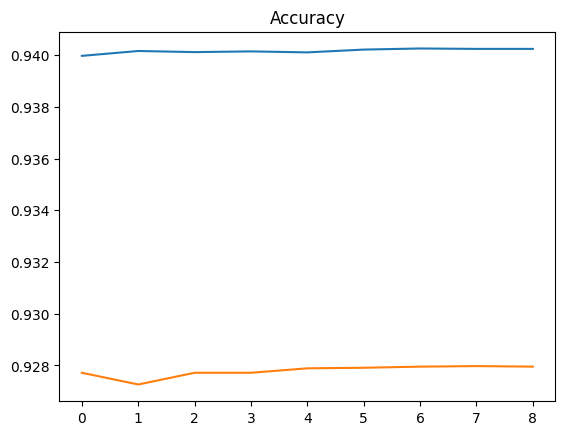

In [27]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.show()

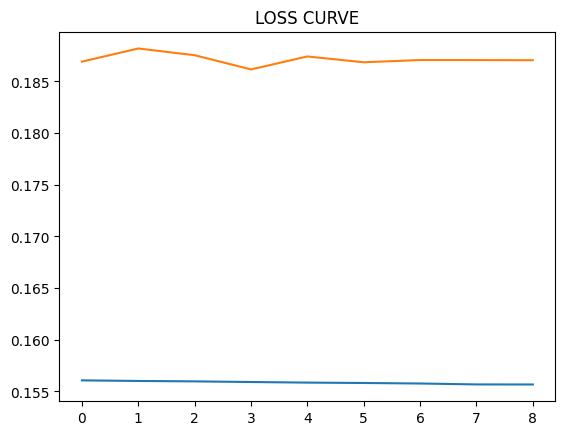

In [28]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LOSS CURVE')
plt.show()